# Standard field processing notebook

This is a Jupyter notebook written to provide a framework for processing standard fields from Landoldt 2013AJ....146..131L. I split it up into sections to do specific tasks (i.e. one section for plate-solving for an image's WCS, one section for merging images, etc), so feel free to just use the sections relevant to you.

1. **Import** the Landoldt tables and standard field images
2. **Plate-solve** for each standard field
3. **Calibrate** each standard field using associated flats (or darks) and a master bias frame
4. **Merge** calibrated fields into master fields per filter
5. **Identify** stars in each master field and (optionally) save their positions to a .csv
6. Perform **photometry** on each master field
7. Identify **coefficients & constants** according to the [AAVSO Guide to CCD Photometry](https://www.aavso.org/sites/default/files/publications_files/ccd_photometry_guide/CCDPhotometryGuide.pdf).

Make sure `astropy`, `ccdproc` and `astrometry` are all installed. Astrometry will need to download ~10 GB of field data, so I recommend it be done on a good network connection like at the UW. 

To use this notebook, put your standard fields in a directory called `standard-data/`. 

**Note**: This notebook assumes each filter has the same exposure time.

---

## Variables

To avoid searching for astrometry matches across the entire sky, indicate the RA/Dec of the field - only use one `std_coord` below.

In [1]:
# astropy imports
import astropy
from astropy import log
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.stats import SigmaClip
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord

# photutils photometry imports
from photutils.psf import PSFPhotometry, IntegratedGaussianPRF
from photutils.detection import DAOStarFinder
from photutils.background import Background2D, MedianBackground

# other astronomy imports
import ccdproc as ccdp
import astrometry

# scipy and numpy
import scipy
import numpy as np

# Misc & OS
import os
import sep
import glob
import logging
from pathlib import Path
import matplotlib.pyplot as plt

# Disable some Astropy warnings when opening fits files
log.setLevel('ERROR')

# Some matplotlib configuration
from matplotlib import rc
plt.style.use(['bmh'])

plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.dpi'] = 200

In [2]:
# RA / Dec in HMS/DMS - only use either this or the one below. 
std_coord = SkyCoord("18 50 34.221 +45 07 26.48", unit=(u.hourangle, u.deg))

# RA / Dec in deg
# std_coord = SkyCoord("348.10 10.79", unit=(u.deg, u.deg))

# Constants
STANDARD_FIELD_PATH = Path("data/standard-fields") # Put standard field images in here
CALIBRATION_FRAME_PATH = Path("data/calibration-frames") # Put master calibration frames in here
LANDOLDT_TABLE_PATH = Path("landoldt-tables") # Should already have three Landoldt tables here

FITS_SAVE_PATH = Path("results/wcs-fits") # Save .fits files with WCS info added to header
MATCHED_SAVE_PATH = Path("results/matched-standard-stars") # Save identified stars list as a .csv

# Toggles
CALIBRATE_IMGS = False # Calibrate using frames in CALIBRATION_FRAME_PATH. Disable if images already calibrated.
VISUALIZE_MATCHES = True # Show matched stars on the field.
SAVE_CSV = True # Save to IMG_FILENAME.csv
SAVE_WCS_FITS = True # Save new .fits files with WCS information included in the header for each standard field.
ENABLE_PLOT_ANNOTATE = True # Annotate stars on the transformation coefficient section

## 1. Imports

### Landoldt Tables

Should have `landoldt-pos50dec.csv`, `landoldt-neg50dec.csv`, `landoldt-equator.csv` in `landoldt-tables/`. If you are only observing in the northern hemisphere, you may omit the -equator and  -neg50dec.csv, and visa versa, but the iterator should be quick enough even on slower systems the speed increase will be negligible.

In [3]:
landoldt_pos50 = ascii.read(LANDOLDT_TABLE_PATH / "landoldt-pos50dec.csv")
landoldt_neg50 = ascii.read(LANDOLDT_TABLE_PATH / "landoldt-neg50dec.csv")
landoldt_eq = ascii.read(LANDOLDT_TABLE_PATH / "landoldt-equator.csv")

standard_stars = [landoldt_pos50, landoldt_neg50, landoldt_eq]

for table in standard_stars:
    table["skycoord"] = None

    for row in table:
        c = SkyCoord("{} {}".format(row["RA(J2000.0)"], row["DEC(J2000.0)"]), unit=(u.hourangle, u.deg))
        row["skycoord"] = c

### Standard field and calibration image imports

Import the standard field `.fits` files from `data/standard-data/` and *master* calibration frames (flats and biases) from `data/calibration-frames`. 

In [4]:
# Create IFCs for standard fields and calibrationf rames
std_fields_ifc = ccdp.ImageFileCollection(STANDARD_FIELD_PATH)
calibration_ifc = ccdp.ImageFileCollection(CALIBRATION_FRAME_PATH)

## 2. Plate solve for each field

Now, we'll plate-solve for each image using the downloaded Astrometry data fields. If a match is found, the output will show 'MATCH' - otherwise you may need to adjust your position parameters.

Change the thresholds and areas below if you find you have fewer stars in your image than you can see visually.

In [5]:
# Threshold distinguishes stars from the background, while min_area represents the minimum area a pixel region must have to be identified as a "star".
thresh = 1.7
min_area = 50

In [6]:
# Create astrometry solver
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory='astrometry_cache',
        scales={0,3},
    )
)

# Set up astrometry position hint to avoid iterating over full sky
poshint = astrometry.PositionHint(
    ra_deg=np.int64(std_coord.ra),
    dec_deg=np.int64(std_coord.dec),
    radius_deg=1
)

astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (2569465 => 893 FITS blocks) is not equal to size of table "sweep" (12006720 => 4169 FITS blocks).
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (7333319 => 2547 FITS blocks) is not equal to size of table "sweep" (59762880 => 20751 FITS blocks).
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (7732495 => 2685 FITS blocks) is not equal to size of table "sweep" (50722560 => 17612 FITS blocks).
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (7698868 => 2674 FITS blocks) is not equal to size of table "sweep" (8749440 => 3038 FITS blocks).


In [7]:
# Set logging level to ignore wcs errors
logging.getLogger().setLevel(logging.FATAL)

# Get a dict of image ccds
ccds = {file_name: ccd for ccd, file_name in std_fields_ifc.ccds(return_fname=True, ccd_kwargs={'unit': u.adu})}

# Remove previous files (if save enabled)
if SAVE_WCS_FITS:
    # Delete any files within FITS_SAVE_PATH
    files = glob.glob(str(FITS_SAVE_PATH / "*"))
    for f in files:
        os.remove(f)

n = 0
for fname, img in ccds.items():
    data = img.data.astype(np.int32)
        
    # Estimate the background and subtract it from the image
    bkg = sep.Background(data)
    signal = data - bkg    
    
    # Extract sources from the image
    sources = sep.extract(signal, thresh=thresh, err=bkg.globalrms, minarea=min_area)

    x, y = sources['x'], sources['y']
    stars_xy = list(zip(x, y))
    
    # ... solve for some supplied coords
    solution = solver.solve(
        stars=stars_xy,
        size_hint=astrometry.SizeHint(0.4,0.5),
        position_hint=poshint,
        solution_parameters=astrometry.SolutionParameters()
    )
    
    # if the solution has a match, show it 
    if solution.has_match():
        print("[{} / {}]: MATCH, found {} stars".format(n+1, len(ccds), len(sources)))
        solution_match = solution.best_match()
        wcsobj = solution_match.astropy_wcs()
        for h in wcsobj.to_header():
            ccds[fname].header.update(wcsobj.to_header())
            # ccds[fname].header[h] = wcsobj.to_header()[h]
    else:
        print("[{} / {}]: NO MATCH, {} stars".format(n+1, len(ccds), len(sources)))

    n += 1

    # Save .FITs file with WCS info added (if enabled)
    if SAVE_WCS_FITS:
        # Check if wcs-fits directory exists in results/; create if not
        os.makedirs(FITS_SAVE_PATH, exist_ok=True)

        # Save the HDU
        hdu = img.to_hdu()
        hdu.writeto(FITS_SAVE_PATH / fname, overwrite=True)

[1 / 28]: MATCH, found 34 stars
[2 / 28]: MATCH, found 20 stars
[3 / 28]: MATCH, found 32 stars
[4 / 28]: MATCH, found 20 stars
[5 / 28]: MATCH, found 32 stars
[6 / 28]: MATCH, found 20 stars
[7 / 28]: MATCH, found 17 stars
[8 / 28]: MATCH, found 18 stars
[9 / 28]: MATCH, found 19 stars
[10 / 28]: MATCH, found 20 stars
[11 / 28]: MATCH, found 19 stars
[12 / 28]: MATCH, found 19 stars
[13 / 28]: MATCH, found 19 stars
[14 / 28]: MATCH, found 21 stars
[15 / 28]: MATCH, found 18 stars
[16 / 28]: MATCH, found 19 stars
[17 / 28]: MATCH, found 20 stars
[18 / 28]: MATCH, found 19 stars
[19 / 28]: MATCH, found 20 stars
[20 / 28]: MATCH, found 19 stars
[21 / 28]: MATCH, found 18 stars
[22 / 28]: MATCH, found 18 stars
[23 / 28]: MATCH, found 19 stars
[24 / 28]: MATCH, found 21 stars
[25 / 28]: MATCH, found 21 stars
[26 / 28]: MATCH, found 19 stars
[27 / 28]: MATCH, found 20 stars
[28 / 28]: MATCH, found 19 stars


## 3. Calibrate frames

In [8]:
if CALIBRATE_IMGS:
    # Get the CCDs for the flats and master bias
    combined_flats = {ccd.header['filter']: ccd for ccd in calibration_ifc.ccds(imagetyp='Flat', combined=True)}
    master_bias = list(calibration_ifc.ccds(imagetyp='Bias', combined=True))[0]

In [9]:
# Re-open IFC due to ccdproc.wcs_project bug
std_fields_ifc = ccdp.ImageFileCollection(FITS_SAVE_PATH)
ccds = {file_name: ccd for ccd, file_name in std_fields_ifc.ccds(return_fname=True)}

if CALIBRATE_IMGS:
    # Calibrate each frame with the respective flat and bias
    for fname, img in ccds.items():
        calib_img = ccdp.ccd_process(
            img, 
            master_bias=master_bias,
            # master_flat=combined_flats[img.header['filter']],
            gain_corrected=False
        )
        ccds[fname] = calib_img 
        
        fig = plt.figure()
        ax = fig.add_subplot(121)
        show_image(img, fig=fig, ax=ax)

        ax = fig.add_subplot(122)
        show_image(calib_img, fig=fig, ax=ax)

## 4. Merge fields

Create master fields on a per-filter basis by using `ccdproc.wcs_project` (see https://ccdproc.readthedocs.io/en/latest/image_combination.html#combination-with-image-transformation-and-alignment).

In [10]:
# We'll use the WCS of the first image ([0]) for this - adjust to a later image if bad sample
target_header = list(ccds.values())[0].header
target_wcs = list(ccds.values())[0].wcs

reprojected_ccds = {img.header['filter']: [] for img in ccds.values()}

for fname, img in ccds.items():
    # Reproject each image onto target_wcs
    proj_img = ccdp.wcs_project(img, target_wcs)

    # Add it to the corresponding filter list in reprojected_ccds
    reprojected_ccds[img.header['filter']].append(proj_img)

for filt, lst in reprojected_ccds.items():
    print(filt, len(lst))

combined_fields = {}
for filt in reprojected_ccds.keys():
    combiner = ccdp.Combiner(reprojected_ccds[filt])

    # Clip out extreme values (hot pixels and negative pixels) while we're at it
    combiner.sigma_clipping()

    # Combine each image using average_combine
    combined_fields[filt] = combiner.average_combine()

# Add exptimes to a per-filter list for use later
filt_exptimes = {img.header['filter']: img.header['exptime'] for img in ccds.values()}

V 14
B 14


/Users/aethio/Projects/Notebooks/Standard-Fields/venv/lib/python3.12/site-packages/ccdproc/combiner.py:548: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/Users/aethio/Projects/Notebooks/Standard-Fields/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# 5. Identify standard stars

For each combined field, find Landoldt stars by identifying which Landoldt RA / Dec coordinates "fit" inside the WCS field. 

In [11]:
# Max distance between pixel coordinates and WCS coordinates - change this for unfocused images or dense star fields where the stars are close to one another
max_star_difference = 8

In [12]:
identified_stars = {}

# Iterate over every image and its associated file name
for filt, img in combined_fields.items():
    # Create a table to associate pixel values with RA/Dec and image location
    std_table = Table()

    # Estimate the background and subtract it from the image
    bkg = sep.Background(img.data)
    signal = img.data - bkg
    # img.data = signal
    
    # Extract sources from the image using the thresholds created in 4.
    sources = sep.extract(signal, thresh=thresh, err=bkg.globalrms, minarea=min_area)

    # Use the target_wcs from earlier
    w = target_wcs

    # Add automatically identified star pixel locations to table
    std_table['x'] = sources['x']
    std_table['y'] = sources['y']

    # Try to associate star pixel locations with star names
    std_table['main_id'] = None
    std_table['RA'] = None
    std_table['Dec'] = None
    std_table['V'] = None
    std_table['B-V'] = None
    std_table['B'] = None
    
    for standard_list in standard_stars:
        for row in standard_list:
            # Get standard star details
            star = row['Star']
            coord = row['skycoord']

            # Continue if standard coord not within area
            if not w.footprint_contains(coord):
                continue

            # Get image transform of RA / Dec
            pixels = w.world_to_pixel(coord)

            dist = scipy.spatial.distance.cdist(
                np.array([std_table['x'], std_table['y']]).T, 
                np.array([[pixels[0]], [pixels[1]]]).T
                )

            # add dist to phot_table
            std_table['dist'] = dist

            # Stars should be within 8 pixels
            mask = (std_table['dist'] < max_star_difference).flatten()
            std_table['main_id'][mask] = star
            std_table['RA'][mask] = coord.ra
            std_table['Dec'][mask] = coord.dec
            std_table['V'][mask] = row['V']
            std_table['B-V'][mask] = row['B-V']
            std_table['B'][mask] = np.float64(row['V'])+np.float64(row['B-V'])

    # Print the number of matches compared with the number of stars
    print("Matched {} out of {} stars".format(np.count_nonzero(std_table['main_id'] != None), len(std_table)))

    # Remove rows from table where 'main_id' is None
    std_table.remove_rows(std_table['main_id'] == None)
    
    # ... and dist column
    std_table.remove_column('dist')

    # ... and add it to a table, associating with the corresponding fname
    identified_stars[filt] = std_table.copy(copy_data=True)

Matched 12 out of 84 stars
Matched 12 out of 59 stars


### Save the fields and show them (if enabled in constants section)

In [13]:
for filt, table in identified_stars.items():
    # Get the corresponding identified stars table
    std_table = identified_stars[filt]
        
    # Table saving
    if SAVE_CSV:
        file_name = "{}-{}-{}".format(target_header['comment'], filt, filt_exptimes[filt]) + ".csv"

        # Check if matched_csvs directory exists in results/; create if not
        os.makedirs(os.path.dirname("./results/matched-standard-stars/"), exist_ok=True)

        # Save to IMG_FILENAME.csv
        std_table.write("./results/matched-standard-stars/" + file_name, overwrite=True)

### Visualization

Helper function below to get a min/max value for matplotlib; I collapse it to save space.

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.nddata.blocks import block_reduce
from astropy import visualization as aviz

def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='gray', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None,
               title=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """

    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)

    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    if title:
        ax.set_title(title)

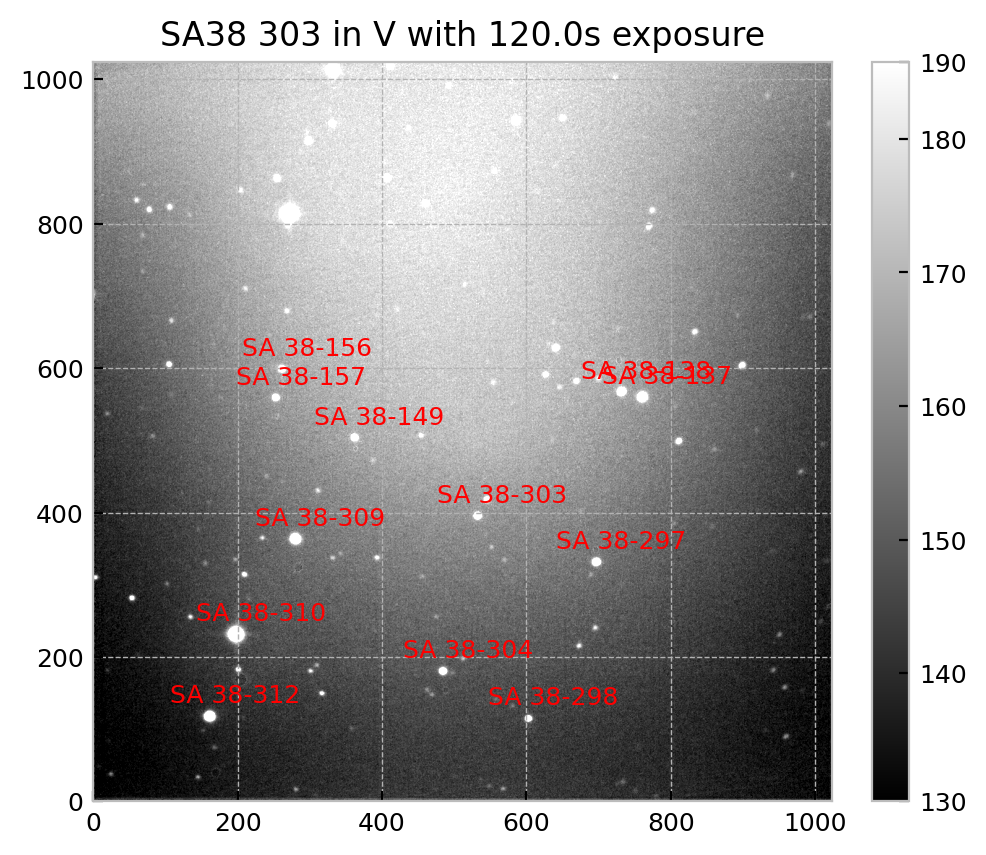

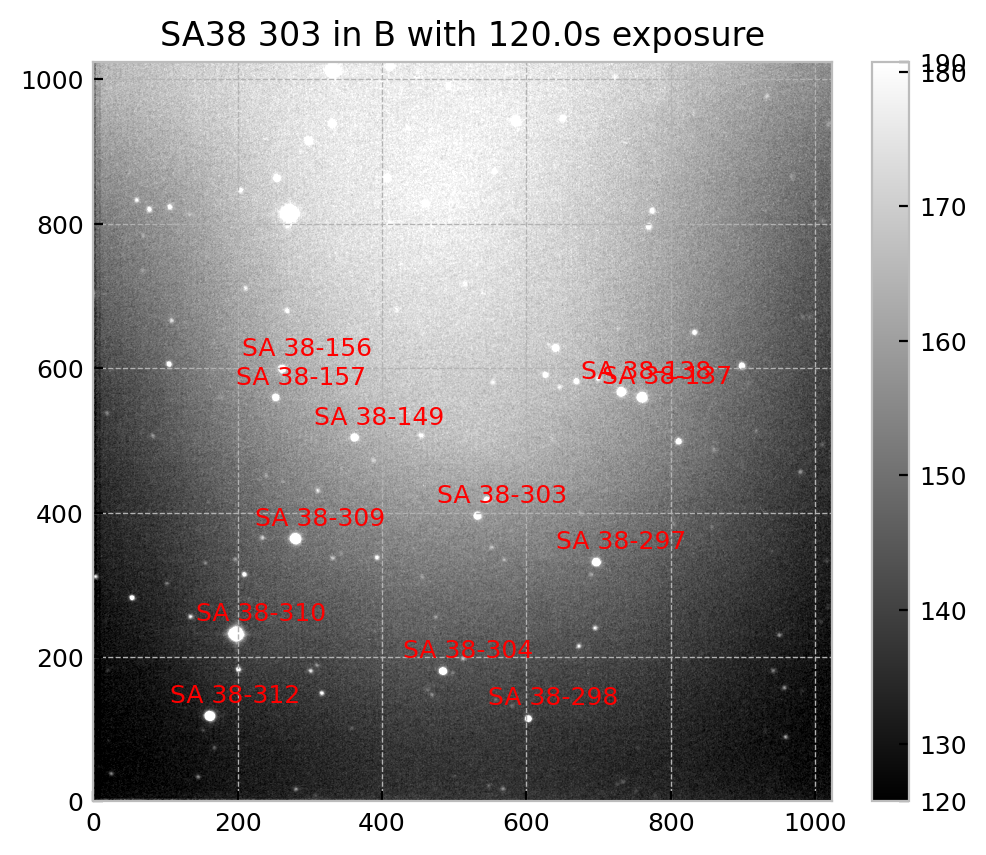

In [15]:
if VISUALIZE_MATCHES:
    for filt, table in identified_stars.items():
        # Set up figure for later saving
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # Show the image
        show_image(combined_fields[filt], title="{} in {} with {}s exposure".format(target_header['comment'], filt, filt_exptimes[filt]), fig=fig, ax=ax)

        # Label stars according to table
        if len(std_table) > 1:
            for row in std_table:
                plt.annotate(row['main_id'], xy=(row['x'], row['y']), xytext=(row['x']-55, row['y']+20), color='red')        

## 6. Photometry

For each star, we'll run 

In [16]:
for filt, table in identified_stars.items():
    img = combined_fields[filt]

    # We need to background subtract for PSFPhot
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(img.data, (50, 50), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

    img_bcksub = img.data - bkg.background

    # Initial params for model
    init_params = QTable()
    init_params['x'] = [row['x'] for row in table]
    init_params['y'] = [row['y'] for row in table]

    # Create PSF photometry model
    psf_model = IntegratedGaussianPRF(flux=1, sigma=6)
    fit_shape = (11, 11)
    finder = DAOStarFinder(6.0, 6.4)
    psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                            aperture_radius=6.3)

    # Run the model
    phot_table = psfphot(img_bcksub, init_params=init_params)
    
    # add counts / s column to main table
    phot_table['cps'] = phot_table['flux_fit'] / filt_exptimes[filt]

    # Calculate instrumental magnitude
    m = -2.5 * np.log10(phot_table['cps'])
    phot_table['m'] = m

    # Join the two tables
    mergetable = astropy.table.join(phot_table, table, keys_left=['x_init', 'y_init'], keys_right=['x','y'])

    # Remove the 'xcenter' and 'ycenter' columns, duplicates
    mergetable.remove_column('x_init')
    mergetable.remove_column('y_init')

    # Replace identified_stars table
    identified_stars[filt] = mergetable

## 7. Transformation coefficients

The transformation equations are 
$$
\begin{aligned}
    V = v+\mu_v(b-v)+C_v\\
    B = b+\mu_b(b-v)+C_B
\end{aligned}
$$
where $v$ and $b$ are the calculated instrumental magntiudes in the $v$ and $b$ filters respectively and $V$ and $B$ are the Landoldt "real" magnitudes. The unknowns:

1. $\mu_{v,b}$ are the slopes of the graphs of $(V-v)$ and $(B-b)$ against $(b-v)$.
2. $C_{V,B}$ are the y-intercepts of each of these graphs. 

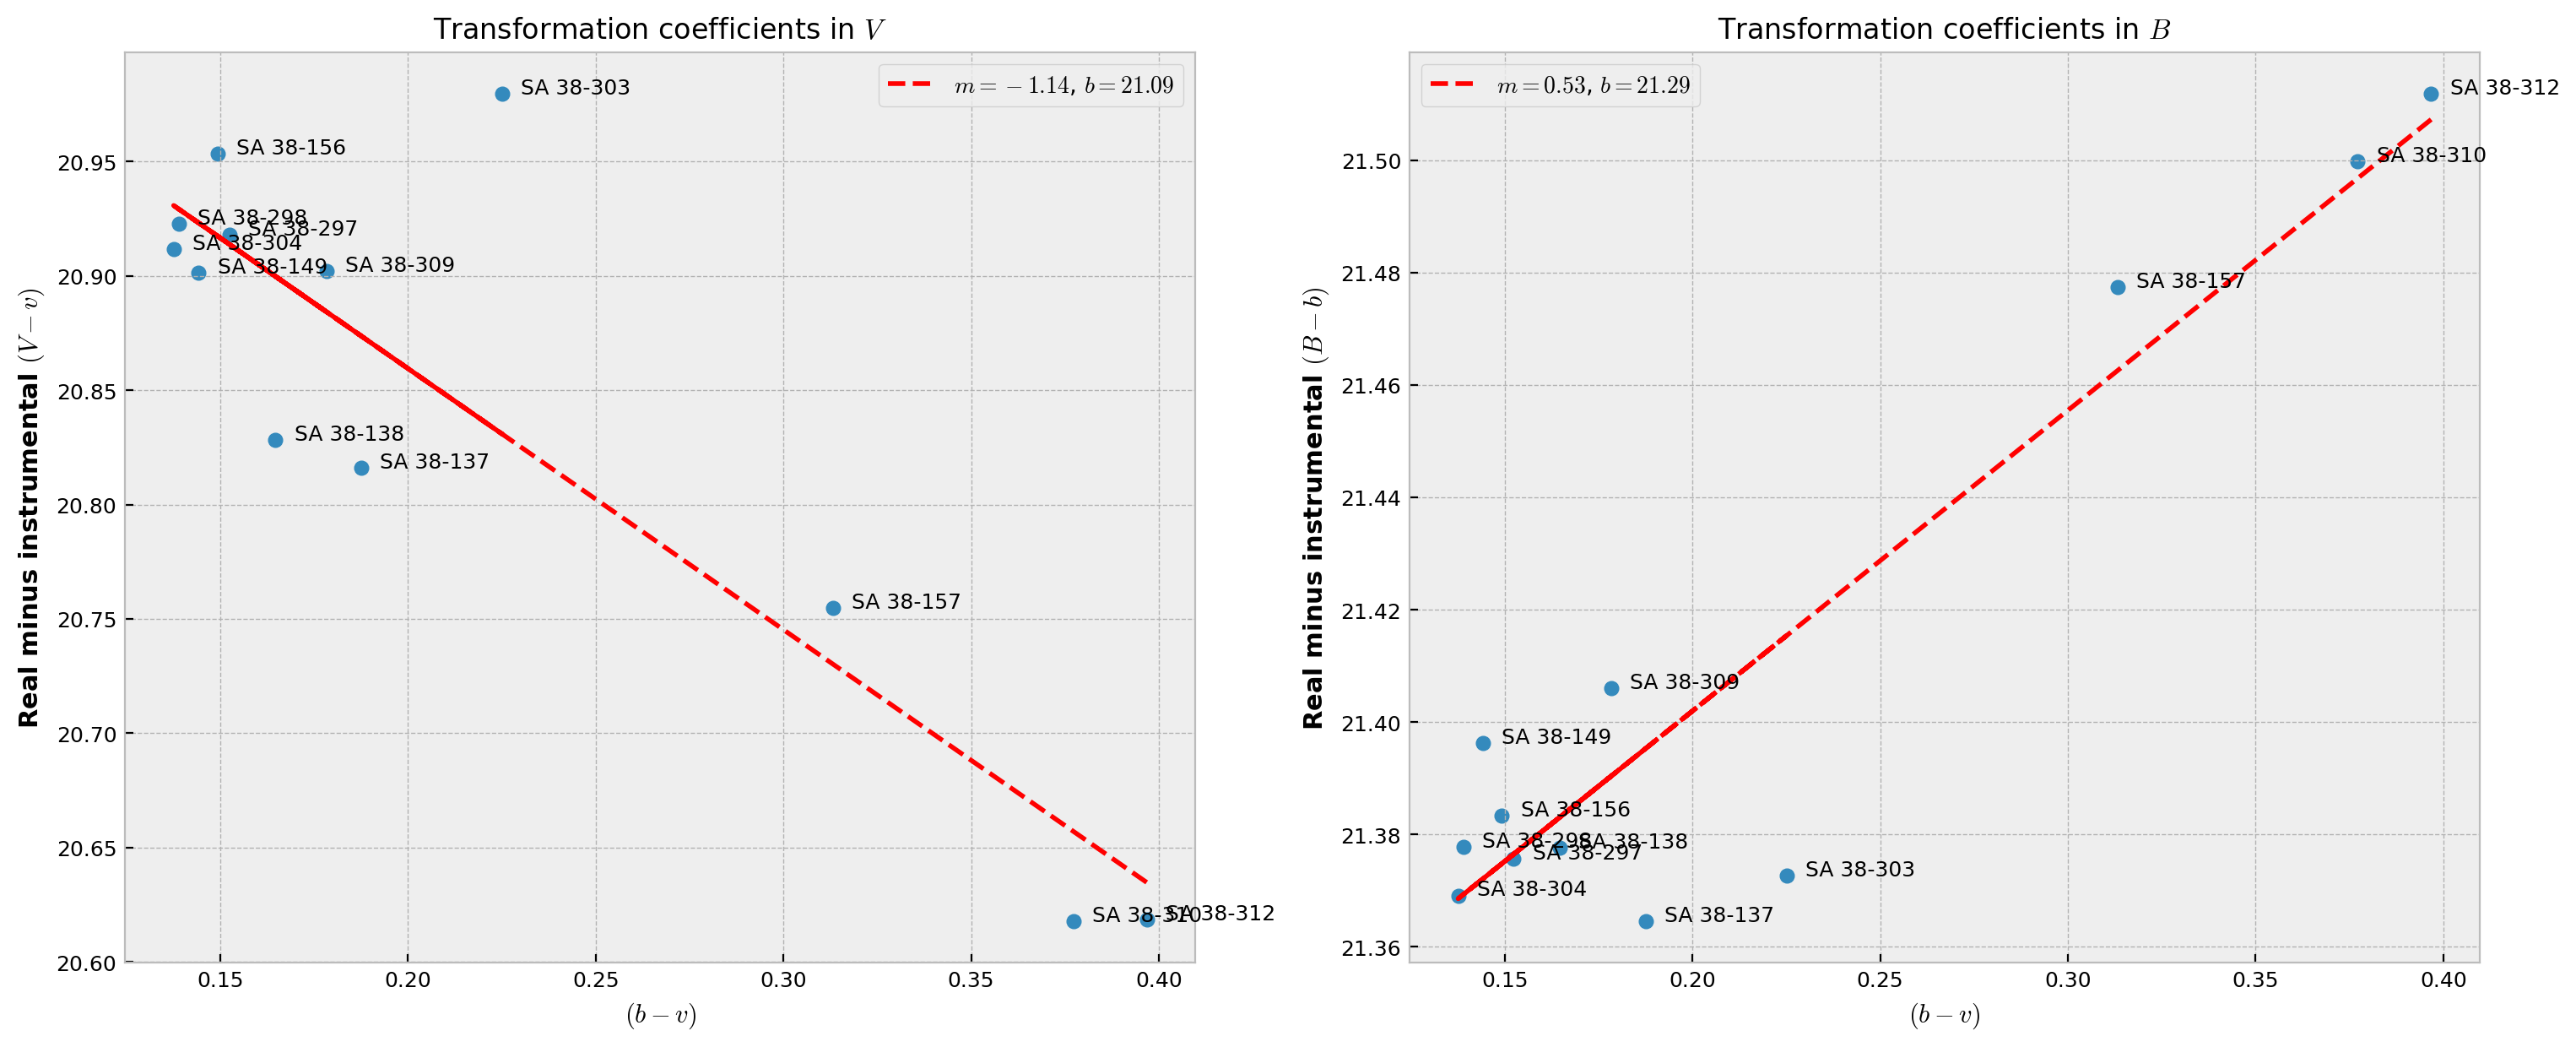

In [17]:
# Create a LoBF function
def linear_fit(x, m, b):
    return(m*x+b)

# Try calculating Vv against b-v
bv_instr = identified_stars['B']['m'] - identified_stars['V']['m'] 
Vv = identified_stars['V']['V'] - identified_stars['V']['m']

# Plot to find transformation coefficients
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(121)
res = scipy.stats.linregress(np.array(bv_instr).astype(float), np.array(Vv).astype(float))
plt.scatter(bv_instr, Vv)
plt.plot(bv_instr, res.slope*bv_instr + res.intercept, '--', c='r', label="$m={:.2f}$, $b={:.2f}$".format(res.slope, res.intercept))

# Annotate
if ENABLE_PLOT_ANNOTATE:
    for i in range(len(bv_instr)):
        star = identified_stars['V'][i]['main_id']
        plt.annotate(xy=(bv_instr[i]+0.005, Vv[i]), text=star)

# Plot configuration
plt.legend()
plt.xlabel("$(b-v)$")
plt.ylabel("Real minus instrumental $(V-v)$")
plt.title("Transformation coefficients in $V$")

# Try calculating Bb against b-v -----------------------------------------
bv_instr = identified_stars['B']['m'] - identified_stars['V']['m'] 
Bb = identified_stars['B']['B'] - identified_stars['B']['m']

# Plot to find transformation coefficients
ax = fig.add_subplot(122)
res = scipy.stats.linregress(np.array(bv_instr).astype(float), np.array(Bb).astype(float))
plt.scatter(bv_instr, Bb)
plt.plot(bv_instr, res.slope*bv_instr + res.intercept, '--', c='r', label="$m={:.2f}$, $b={:.2f}$".format(res.slope, res.intercept))

# Annotate
if ENABLE_PLOT_ANNOTATE:
    for i in range(len(bv_instr)):
        star = identified_stars['B'][i]['main_id']
        plt.annotate(xy=(bv_instr[i]+0.005, Bb[i]), text=star)

# Plot configuration
plt.legend()
plt.xlabel("$(b-v)$")
plt.ylabel("Real minus instrumental $(B-b)$")
plt.title("Transformation coefficients in $B$")

plt.show()